# 규제 선형 회귀

- 학습 데이터 잔차 오류 최소화 + 회귀계수 크기 제어
- alpha 값이 0이면 어쨌든 최소화가 되기 때문에 alpha 값이 무한대가 된다면 w를 0에 가깝게 만들어야 한다.

## 규제 (Regulariation)
- 과적합을 개선하는 방식
- 비용 함수에 alpaha값으로 패널티를 부여해서 회계 계수 값의 크기를 감소

### 릿지
=> L2 (선형 회귀에 큰 회귀 계수 값의 예측 영향도를 감소시키기 위해 회귀 계수값을 작게 만드는)

### 라쏘 
=> L1 (영향력이 작은 회귀 계수를 0으로)
### 엘라스틱넷 
=> L1,L2 (피처가 많은 데이터에 사용)



### 릿지

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso, ElasticNet
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

boston = load_boston()

In [5]:
bostonDF = pd.DataFrame(boston.data , columns=boston.feature_names)

bostonDF['PRICE'] = boston.target
print("Boston 데이터셋 크기 : ", bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace=False)

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds 의 개별 Negative MSE scores : ", np.round(neg_mse_scores, 3))
print("5 folds 의 개별 RMSE scores : ", np.round(rmse_scores, 3))
print("5 folds 의 평균 RMSE : {0:.3f}".format(avg_rmse))

Boston 데이터셋 크기 :  (506, 14)
5 folds 의 개별 Negative MSE scores :  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
5 folds 의 평균 RMSE : 5.518


In [6]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas : 
    ridge = Ridge(alpha = alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788
alpha 1 일 때 5 folds의 평균 RMSE : 5.653
alpha 10 일 때 5 folds의 평균 RMSE : 5.518
alpha 100 일 때 5 folds의 평균 RMSE : 5.330


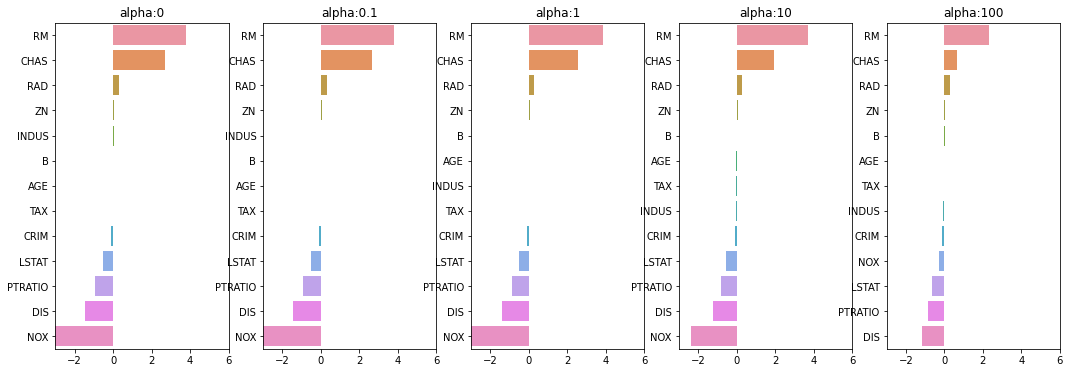

In [7]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    coeff=coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
plt.show()

In [8]:
ridge_alphas = [0, 0.1, 1, 10, 100, 120]
sort_column = 'alpha:' +str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### 라쏘

In [11]:
# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose=True, return_coeff=True):
    
    coeff_df = pd.DataFrame()
    if verbose : print("###### ", model_name, "######")
    for param in params:
        if model_name == 'Ridge': 
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet' :
            model = ElasticNet(alpha = param, l1_ratio = 0.7)
        
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print("alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f}".format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변화하고 이를 DataFrame의 컬럼으로 추가
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname]=coeff
            
    return coeff_df
# end of get_linear_regre_eval

In [12]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n = X_data, y_target_n = y_target)

######  Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189


In [13]:
print(lasso_alphas)

[0.07, 0.1, 0.5, 1, 3]


In [14]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [15]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n=y_target)

######  ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068


In [16]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:' +str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


# 시계열 (Time series data)

In [17]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [18]:
avo = pd.read_csv('avocado.csv')

In [19]:
avo.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [20]:
avo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [21]:
avo.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [22]:
avo.groupby('type').mean()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
type,,,,,,,,,,,
conventional,24.236686,1.158040,1.653213e+06,578611.649925,574805.318859,45405.796798,454390.130901,346721.795885,101457.698855,6210.635065,2016.147929
organic,24.227776,1.653999,4.781121e+04,7311.281600,15411.857724,266.254582,24817.654696,17613.474543,7202.982659,1.197164,2016.147868


In [23]:
avo=avo.loc[(avo.type == 'conventional')&(avo.region == 'TotalUS')]
avo['Date'] = pd.to_datetime(avo['Date'])
data=avo[['Date', 'AveragePrice']].reset_index(drop=True)
data=data.rename(columns = {'Date':'ds', 'AveragePrice' : 'y'})
data.head()

,ds,y
0,2015-12-27,0.95
1,2015-12-20,0.98
2,2015-12-13,0.93
3,2015-12-06,0.89
4,2015-11-29,0.99


<AxesSubplot:xlabel='ds'>

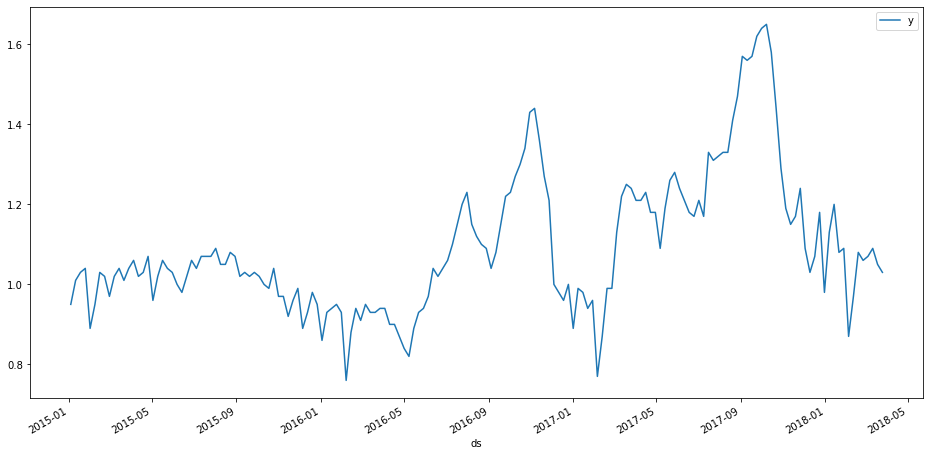

In [24]:
data.plot(x='ds', y='y', figsize=(16,8))
# 무엇을 나타내는 내용인가?

In [25]:
model = Prophet()
model.fit(data)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast.tail()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
529,2019-03-21,1.171972,0.982997,1.248939,1.110063,1.239288,-0.059338,-0.059338,-0.059338,-0.059338,-0.059338,-0.059338,0.0,0.0,0.0,1.112634
530,2019-03-22,1.171861,0.986115,1.251807,1.109747,1.239541,-0.057928,-0.057928,-0.057928,-0.057928,-0.057928,-0.057928,0.0,0.0,0.0,1.113933
531,2019-03-23,1.171750,0.990364,1.255934,1.109432,1.239766,-0.056045,-0.056045,-0.056045,-0.056045,-0.056045,-0.056045,0.0,0.0,0.0,1.115706
532,2019-03-24,1.171640,0.984927,1.252129,1.109032,1.239961,-0.053704,-0.053704,-0.053704,-0.053704,-0.053704,-0.053704,0.0,0.0,0.0,1.117936
533,2019-03-25,1.171529,0.990978,1.250562,1.108611,1.240157,-0.050936,-0.050936,-0.050936,-0.050936,-0.050936,-0.050936,0.0,0.0,0.0,1.120593


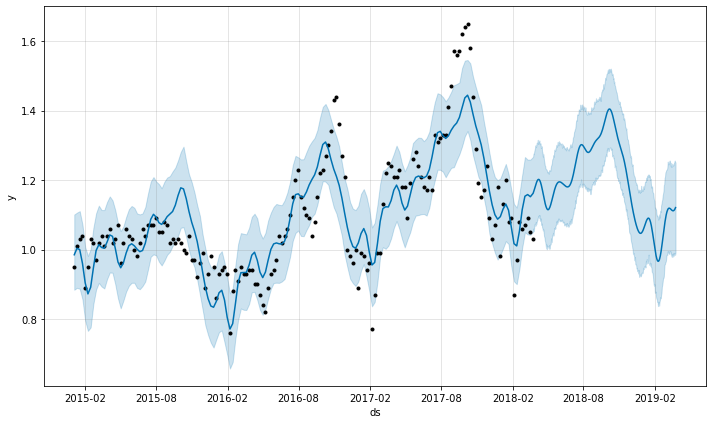

In [26]:
fig1 = model.plot(forecast)

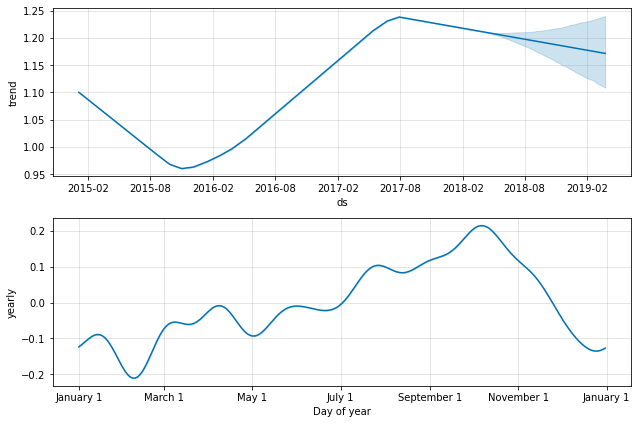

In [27]:
fig2 = model.plot_components(forecast)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
sns.set(style="darkgrid", palette="bright", font_scale=1.5)

In [30]:
df = pd.read_csv('StudentsPerformance.csv')

In [31]:
df


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [32]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [33]:
df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


In [36]:
from wordcloud import WordCloud

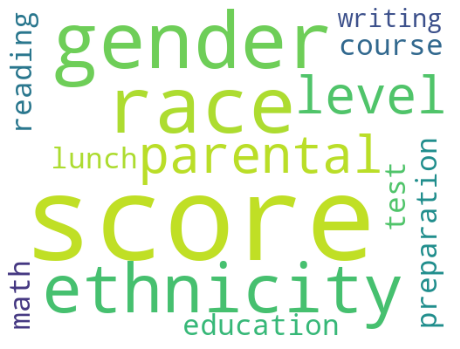

In [37]:
plt.subplots(figsize=(8,8))
wordcloud = WordCloud(
    background_color='white',
    width=512,
    height=384).generate(' '.join(df))

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')
plt.show()

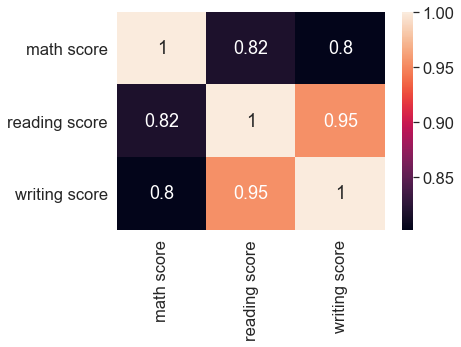

In [39]:
sns.heatmap(df.corr(), annot=True) #실제값을 표시한다.
plt.show()

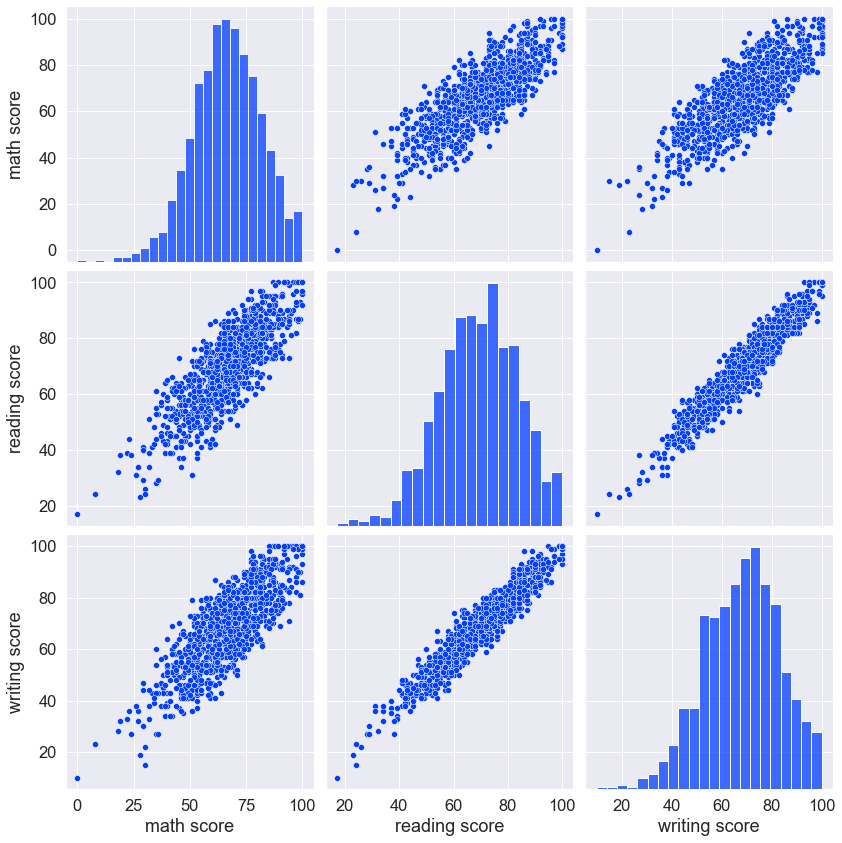

In [41]:
sns.pairplot(df[['math score', 'reading score', 'writing score']], height=4)
plt.show()
# 상관관계가 있는지 없는지 어떻게 알 수 있나요?

In [42]:
def average_score(dt) : 
    return (dt['math score'] + dt['reading score'] + dt['writing score']) / 3

df['average score'] = df.apply(average_score, axis =1)

In [43]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


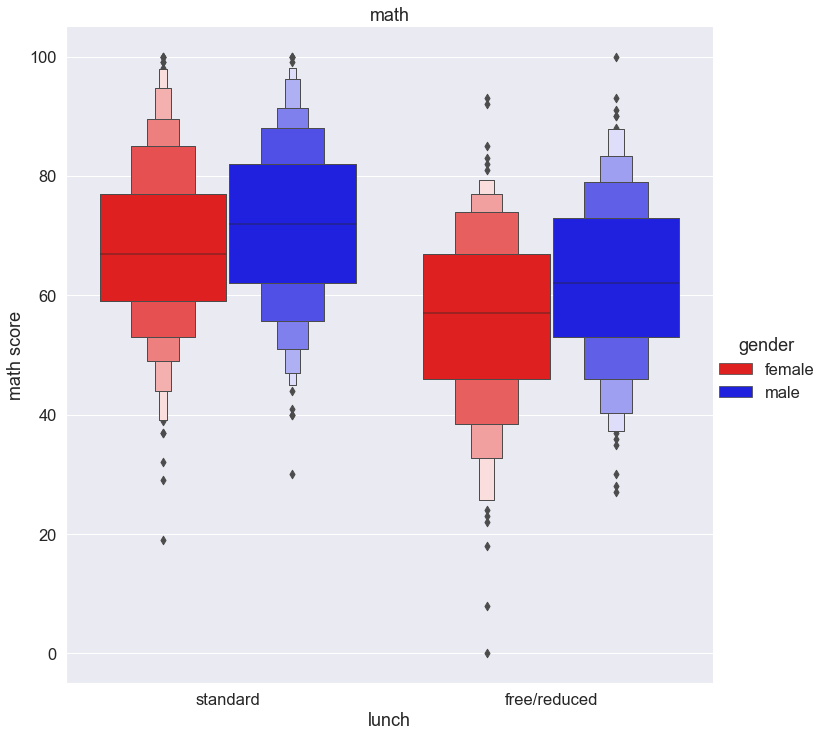

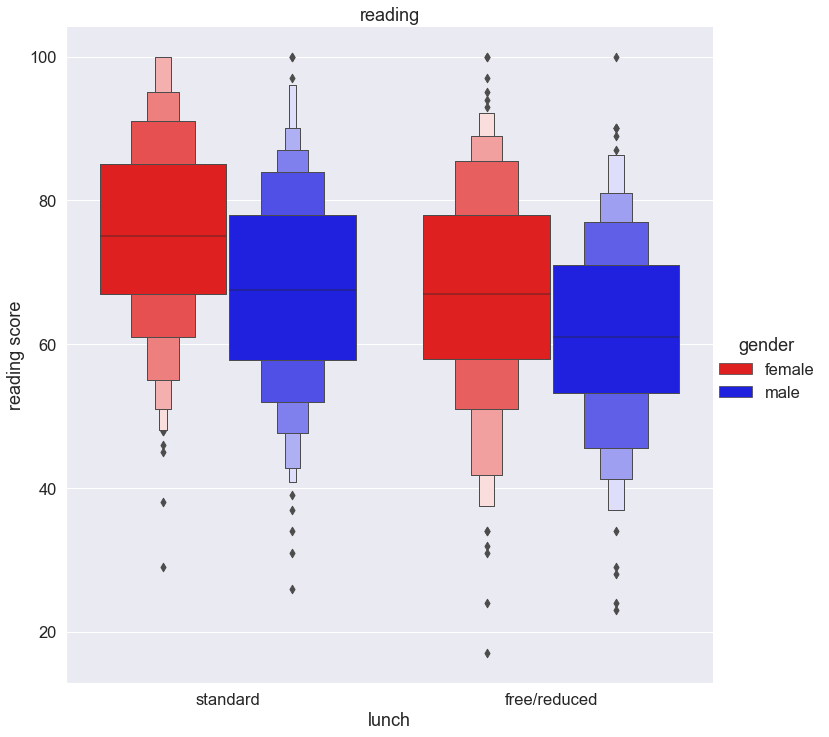

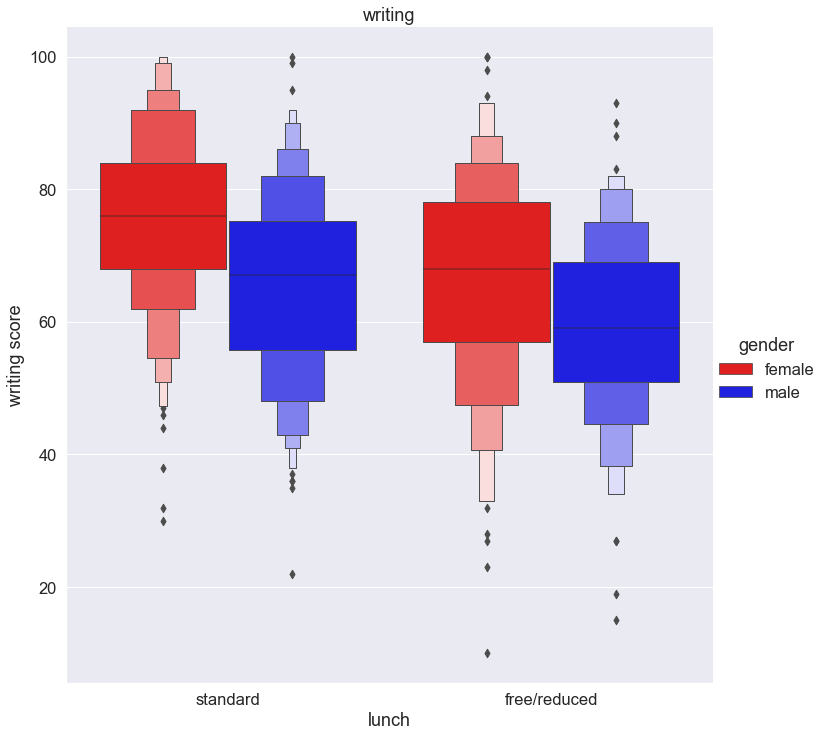

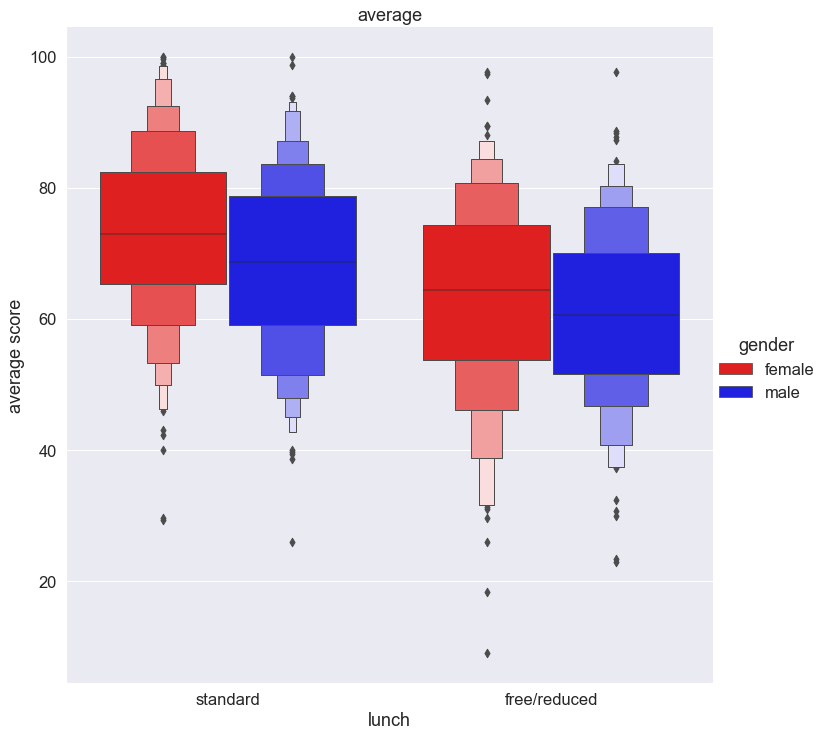

In [44]:
sns.catplot(x="lunch", y="math score", hue='gender', kind='boxen', data=df, height=10, palette=sns.color_palette(['red','blue']))
plt.title('math')

sns.catplot(x="lunch", y="reading score", hue='gender', kind='boxen', data=df, height=10, palette=sns.color_palette(['red','blue']))
plt.title('reading')

sns.catplot(x="lunch", y="writing score", hue='gender', kind='boxen', data=df, height=10, palette=sns.color_palette(['red','blue']))
plt.title('writing')

sns.catplot(x="lunch", y="average score", hue='gender', kind='boxen', data=df, height=10, palette=sns.color_palette(['red','blue']))
plt.title('average')

plt.show()

No handles with labels found to put in legend.


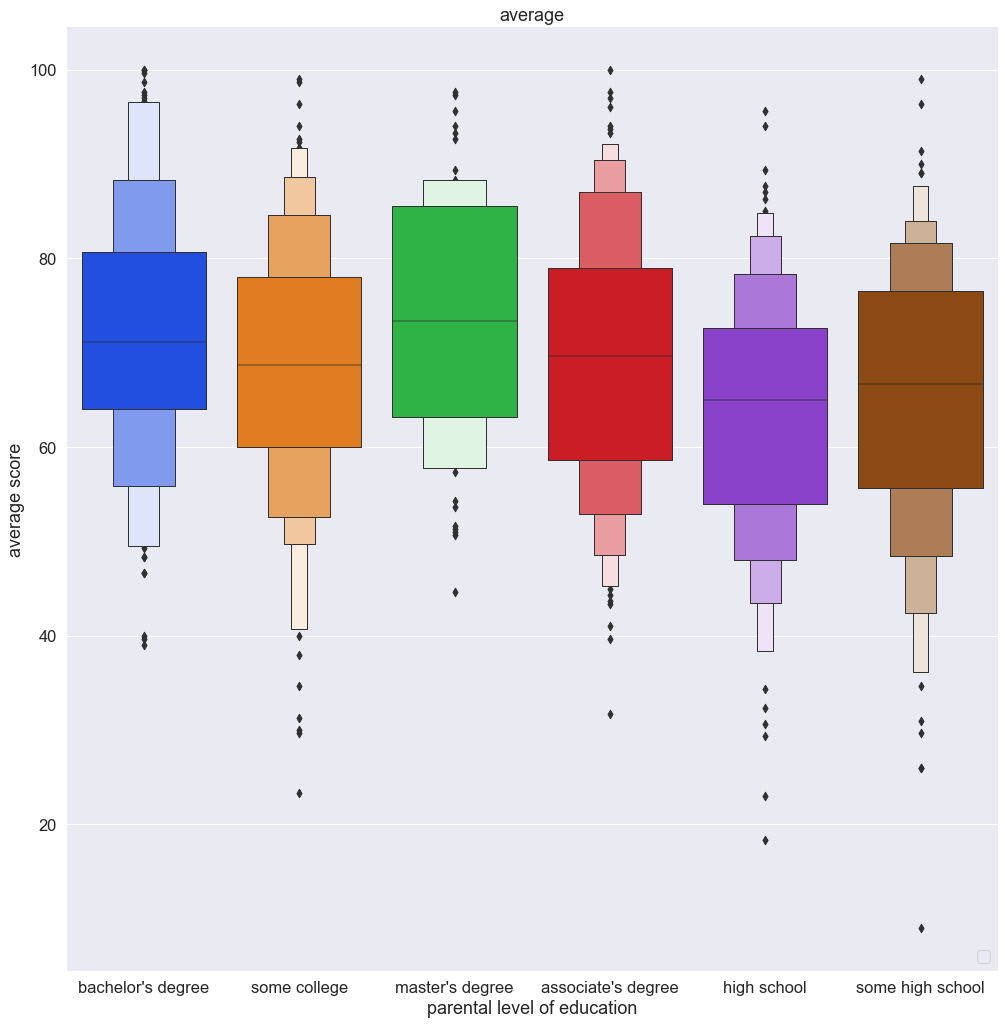

In [31]:
sns.catplot(x="parental level of education", y="average score", kind='boxen', data=df, height=14)
plt.title('average')
plt.legend(loc = 'lower right')

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

In [101]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [102]:
def encode_features(dataDF):
    features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature].astype(str))
        dataDF[feature] = le.transform(dataDF[feature].astype(str))
        print(id(le))

    return dataDF


In [106]:
ndf = encode_features(df)
ndf

2229728683784
2229729334024
2229729334856
2229729334024
2229729334856


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,88,99,95
996,1,2,2,0,1,62,55,55
997,0,2,2,0,0,59,71,65
998,0,3,4,1,0,68,78,77


In [108]:
X_data = ndf.drop(['writing score'], axis=1, inplace=False)
y_target = ndf['writing score']

In [109]:
X_train, X_test, y_train, y_test = train_test_split (X_data, y_target, test_size=0.2, random_state=156)    

In [110]:
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('DT', dt_clf)], voting='soft')

In [111]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.1200


C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
print("{0:.4f}".format(rmse))

3.5075


In [120]:
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds 의 개별 Negative MSE scores : ", np.round(neg_mse_scores, 3))
print("5 folds 의 개별 RMSE scores : ", np.round(rmse_scores, 3))
print("5 folds 의 평균 RMSE : {0:.3f}".format(avg_rmse))

5 folds 의 개별 Negative MSE scores :  [-13.655 -15.29  -13.222 -12.155 -16.485]
5 folds 의 개별 RMSE scores :  [3.695 3.91  3.636 3.486 4.06 ]
5 folds 의 평균 RMSE : 3.758


In [145]:
alphas = [0, 0.1, 1, 10, 100, -10]

for alpha in alphas : 
    ridge = Ridge(alpha = alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 3.752
alpha 0.1 일 때 5 folds의 평균 RMSE : 3.752
alpha 1 일 때 5 folds의 평균 RMSE : 3.752
alpha 10 일 때 5 folds의 평균 RMSE : 3.758
alpha 100 일 때 5 folds의 평균 RMSE : 3.931
alpha -10 일 때 5 folds의 평균 RMSE : 3.762
